In [2]:
#%pip install opencv-python tensorflow matplotlib numpy keras
#%pip install scikit-learn
#%pip install scikit-image
from setuptools import distutils

Total images preprocessed: 10719


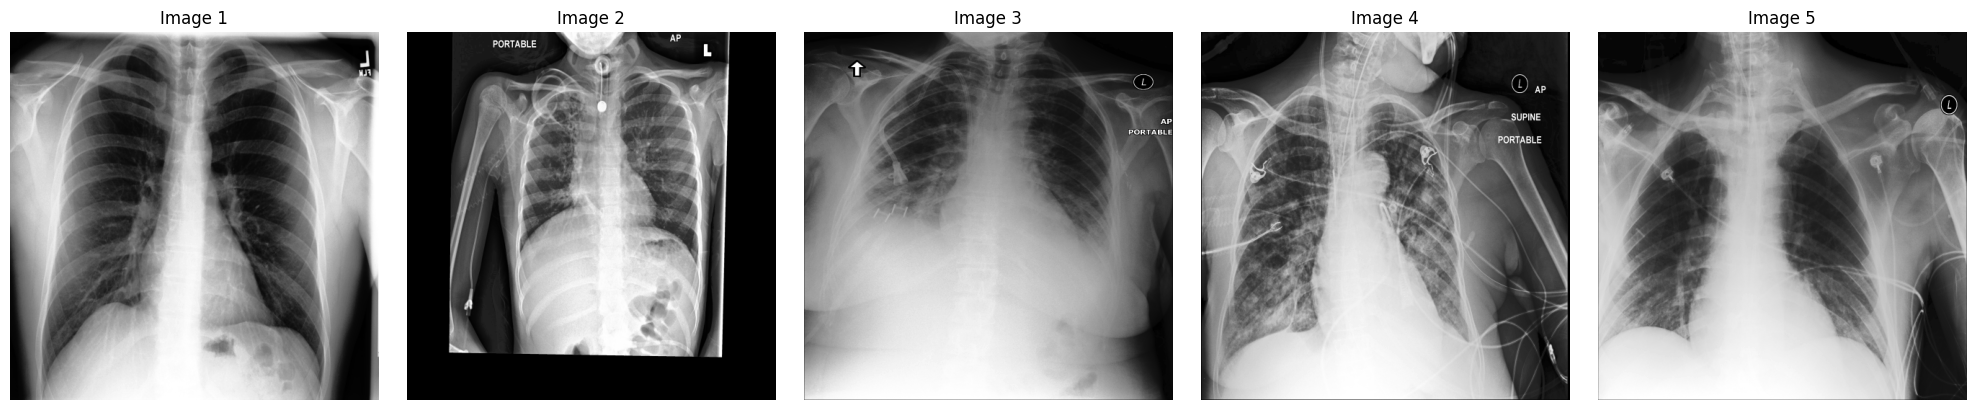

In [3]:
import os
import numpy as np
import pydicom
import cv2
from skimage import exposure
import matplotlib.pyplot as plt

def preprocess_dicom(dicom_path):
    # Read DICOM file
    dicom = pydicom.dcmread(dicom_path)
    
    # Convert to numpy array
    image = dicom.pixel_array.astype(np.float32)
    
    # Normalize pixel values
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Apply histogram equalization for contrast enhancement
    image = exposure.equalize_hist(image)
    
    # Resize image to a standard size (e.g., 512x512)
    image = cv2.resize(image, (512, 512))
    
    return image

def preprocess_all_and_display(folder_path, num_display=5):
    preprocessed_images = []
    
    # Preprocess all images
    for filename in os.listdir(folder_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(folder_path, filename)
            preprocessed = preprocess_dicom(file_path)
            preprocessed_images.append(preprocessed)
    
    print(f"Total images preprocessed: {len(preprocessed_images)}")
    
    # Display first num_display preprocessed images
    fig, axes = plt.subplots(1, num_display, figsize=(20, 4))
    for i in range(num_display):
        axes[i].imshow(preprocessed_images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()
    
    return preprocessed_images

# Usage
folder_path = 'dicom_files'
all_preprocessed_images = preprocess_all_and_display(folder_path)

## TENSORFLOW SEX PREDICTION

In [2]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Optionally, set memory growth to true to only allocate necessary GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, using CPU instead.")

No GPU found, using CPU instead.


In [1]:
import tensorflow as tf
print(tf.__version__)

2.16.2


NameError: name 'nvcc' is not defined

In [4]:
import os
import numpy as np
import pydicom
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

def extract_metadata(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    return {
        'PatientID': dicom.PatientID,
        'PatientSex': dicom.PatientSex,
        'PatientAge': dicom.PatientAge if 'PatientAge' in dicom else None,
        'StudyDate': dicom.StudyDate,
        'Modality': dicom.Modality,
        'BodyPartExamined': dicom.BodyPartExamined if 'BodyPartExamined' in dicom else None,
    }

def prepare_dataset(folder_path):
    metadata = []
    image_paths = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(folder_path, filename)
            metadata.append(extract_metadata(file_path))
            image_paths.append(file_path)
    
    df = pd.DataFrame(metadata)
    df['ImagePath'] = image_paths
    
    # Convert PatientSex to binary (assuming 'M' and 'F' are the only values)
    df['PatientSex'] = df['PatientSex'].map({'M': 0, 'F': 1})
    
    return df

# Custom data generator to handle large datasets
class DicomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = np.array([preprocess_dicom(path) for path in batch_paths])
        return batch_images, np.array(batch_labels)

# Prepare the dataset
folder_path = 'dicom_files'
df = prepare_dataset(folder_path)

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['PatientSex'], random_state=42)

# Create data generators
train_gen = DicomDataGenerator(train_df['ImagePath'].tolist(), train_df['PatientSex'].tolist())
test_gen = DicomDataGenerator(test_df['ImagePath'].tolist(), test_df['PatientSex'].tolist())

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


Total samples: 10719
Training samples: 8575
Testing samples: 2144


## CNN 1 simple

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape=(512, 512, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create and train the model
cnn_model = create_cnn_model()
history = cnn_model.fit(train_gen, epochs=10, validation_data=test_gen)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy:.4f}")

c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.6140 - loss: 0.9750 - val_accuracy: 0.7327 - val_loss: 0.5113
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7336 - loss: 0.5251 - val_accuracy: 0.7696 - val_loss: 0.4808
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.7926 - loss: 0.4310 - val_accuracy: 0.7985 - val_loss: 0.4216
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.8585 - loss: 0.3232 - val_accuracy: 0.8078 - val_loss: 0.4416
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.9001 - loss: 0.2368 - val_accuracy: 0.8190 - val_loss: 0.4914
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9426 - loss: 0.1461 - val_accuracy: 0.8237 - val_loss: 0.5482
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.9592 - loss: 0.0975 - val_accuracy: 0.8125 - val_loss: 0.7338
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.9706 - loss: 0.0731 - val_accuracy: 0.840

KeyboardInterrupt: 

## CNN 1 - Interpretation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
import shap

# 1. Visualize Filters and Feature Maps
def visualize_filters(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    
    n_filters, ix = filters.shape[3], 1
    for i in range(n_filters):
        f = filters[:, :, :, i]
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, 0], cmap='gray')
        ix += 1
    plt.show()

# Usage: visualize_filters(cnn_model, 'conv2d')

def visualize_feature_maps(model, img, layer_name):
    layer_output = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = layer_output.predict(img.reshape(1, 512, 512, 1))
    
    plt.figure(figsize=(20, 10))
    for i in range(min(64, feature_maps.shape[3])):
        plt.subplot(8, 8, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage: visualize_feature_maps(cnn_model, sample_image, 'conv2d')

# 2. Saliency Maps
def compute_saliency_map(model, img):
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img.reshape(1, 512, 512, 1), dtype=tf.float32)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
    
    grads = tape.gradient(predictions, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)
    
    plt.imshow(img.reshape(512, 512), cmap='gray')
    plt.imshow(saliency_map[0], cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

# Usage: compute_saliency_map(cnn_model, sample_image)

# 3. Confusion Matrix and Classification Report
y_pred = cnn_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_gen.labels

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# 4. SHAP (SHapley Additive exPlanations) Values
explainer = shap.DeepExplainer(cnn_model, test_gen[0][0])
shap_values = explainer.shap_values(test_gen[0][0])

shap.image_plot(shap_values, -test_gen[0][0])

# 5. Activation Maximization
def activation_maximization(model, layer_name, filter_index):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, 512, 512, 1)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Usage: activation_maximization(cnn_model, 'conv2d', 0)

C:\Users\alexc\AppData\Local\Temp\ipykernel_17428\3669795761.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PatientAge'] = pd.to_numeric(df['PatientAge'].str.replace('[^0-9]', '', regex=True), errors='coerce')
C:\Users\alexc\AppData\Local\Temp\ipykernel_17428\3669795761.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StudyDate'] = pd.to_datetime(df['StudyDate'], format='%Y%m%d', errors='coerce')
C:\Users\alexc\AppData\Local\Temp\ipykernel_17428\3669795761.py:15: SettingWithCopyWarning: 
A

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

## CNN 2 - Disease prediction


In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

# Load and preprocess data
def load_dicom(path):
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype(np.float32)

# Load CSV file
df = pd.read_csv('train-rle.csv')
df['has_pneumothorax'] = df['EncodedPixels'].apply(lambda x: 0 if x == '-1' else 1)

# Create a data generator
class PneumothoraxDataGenerator(Sequence):
    def __init__(self, image_ids, labels, batch_size=32, img_size=(512, 512)):
        self.image_ids = image_ids
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = np.array([load_dicom(f'dicom_files/{image_id}.dcm') for image_id in batch_ids])
        batch_images = np.expand_dims(batch_images, axis=-1)  # Add channel dimension

        return batch_images, np.array(batch_labels)

# Split data
train_ids, val_ids, train_labels, val_labels = train_test_split(
    df['ImageId'], df['has_pneumothorax'], test_size=0.2, stratify=df['has_pneumothorax'], random_state=42
)

# Create data generators
train_gen = PneumothoraxDataGenerator(train_ids, train_labels)
val_gen = PneumothoraxDataGenerator(val_ids, val_labels)

# Create model
def create_model(input_shape=(512, 512, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and train the model
model = create_model()
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_gen)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
predictions = model.predict(val_gen)
predicted_classes = (predictions > 0.5).astype(int)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(val_labels, predicted_classes))

NameError: name 'dicom_files' is not defined

In [6]:
import pandas as pd

# List to store patient metadata
patient_metadata = []

# Extract metadata from each DICOM file
for dicom_file in dicom_files:
    dicom_data = pydicom.dcmread(dicom_file)
    metadata = {
        "File": dicom_file,
        "PatientID": dicom_data.PatientID if 'PatientID' in dicom_data else "Unknown",
        "PatientSex": dicom_data.PatientSex if 'PatientSex' in dicom_data else "Unknown",
        "PatientAge": dicom_data.PatientAge if 'PatientAge' in dicom_data else "Unknown",
    }
    patient_metadata.append(metadata)

# Convert to pandas DataFrame
metadata_df = pd.DataFrame(patient_metadata)

# Display the first 5 rows of the DataFrame
metadata_df.head()


,File,PatientID,PatientSex,PatientAge
0,dicom_files\1.2.276.0.7230010.3.1.4.8323329.10...,17d405a3-a0d2-4901-b33a-63906aa48d9f,M,38
1,dicom_files\1.2.276.0.7230010.3.1.4.8323329.10...,8ab1ffda-8b65-4914-95d6-2e549e328666,F,10
2,dicom_files\1.2.276.0.7230010.3.1.4.8323329.10...,bfef51d3-6541-4792-bac1-d21d41ee60fd,F,50
3,dicom_files\1.2.276.0.7230010.3.1.4.8323329.10...,d19d956f-4ddd-4688-81ff-909c85e0e2d9,F,68
4,dicom_files\1.2.276.0.7230010.3.1.4.8323329.10...,cf71a760-f693-4ccf-acd4-a41ff4845a5f,M,65
